In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from torch_geometric.utils import negative_sampling
from utils.snakemake_utils import FileResources
from utils.graph_utils import reconstruct_graph
import seaborn as sns
from utils import snakemake_utils
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
from dataset import airportnet_data
y = airportnet_data.AirportNetDataFrame().get_grouped_col()

In [4]:
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_results/polblog/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['data_one/', 'data_two/', 'data_three/', 'data_four/', 'data_five/']
DATASET = 'polblog'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk"]

TEST_ADJ_FILE='/data/sg/ashutiwa/final_results/polblog/data_one/polblog_test_adj.npz'
k=5

data_five  data_four  data_one	data_three  data_two


# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    # ! ls //data/sg/ashutiwa/final_results/airport/data_one/ | grep test
    #     file = '//data/sg/ashutiwa/final_results/airport/data_one/airport_test_adj.npz'

    num_nodes = A.shape[0]
    edge_index = snakemake_utils.get_edge_index_from_sparse_path(file)
    negative_edge_index = negative_sampling(edge_index=edge_index, num_nodes=num_nodes, num_neg_samples=None, method='sparse', force_undirected=True)
    dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[edge_index[0, i].item()], A[edge_index[1, i].item()]) for i in range(edge_index.shape[1])]),

        "negative_dot": np.array([np.dot(A[negative_edge_index[0, i].item()], A[negative_edge_index[1, i].item()]) for i in range(negative_edge_index.shape[1])])
    })
    return dot

In [8]:
def get_roc_score_(A, df):
    from sklearn.metrics import roc_auc_score
    from sklearn.linear_model import LogisticRegression
    X_ = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    train_df = create_dot_df(A, '../../data_one/airport_adj.npz')
    X = np.concatenate((train_df.positive_dot.values, train_df.negative_dot.values))
    y = np.concatenate((np.ones_like(train_df.positive_dot.values), np.zeros_like(train_df.negative_dot.values)))
    X = scaler.fit_transform(X.reshape(-1, 1))                              
    clf = LogisticRegression().fit(X, y)
    X_ = scaler.transform(X_.reshape(-1, 1))
    
    y_pred = clf.predict_proba(X_)
    y_pred = np.argmax(y_pred, axis=1)
    
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

# GCN ( baseline)

In [9]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

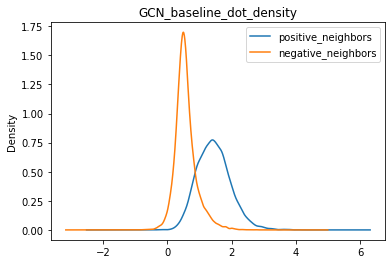

In [10]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [11]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1567.38it/s]


((6120, 2), 0.0018293657232787864, 0.9294280506950169, 0.5261224028568245)

# GCN ( baseline + crosswalk)

In [12]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
A = embs[model]
A.shape


(1224, 128)

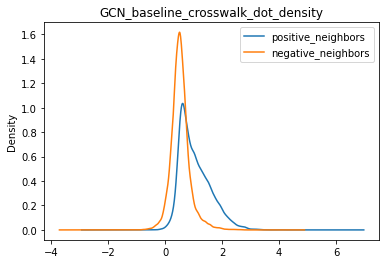

In [13]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [14]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k,batch_size )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2007.00it/s]


((6120, 2), 0.0016158871522523334, 0.8033138054486293, 0.4867953766912046)

# GCN ( r2v)

In [15]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

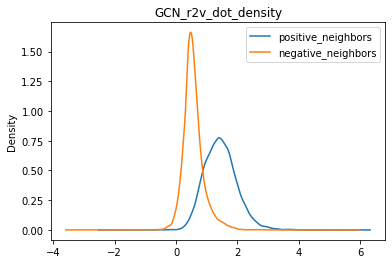

In [16]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [17]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2179.99it/s]


((6120, 2), 0.0018356730662020158, 0.9317536978480719, 0.5211845134030308)

# GCN ( r2v + crosswalk)

In [18]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(1224, 128)

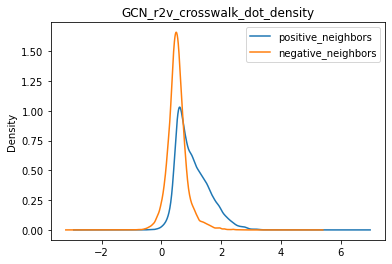

In [19]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [20]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2117.44it/s]


((6114, 2), 0.0016784028273395648, 0.8039918421765601, 0.5014600640875436)

# GAT ( baseline)

In [21]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
A = embs[model]

A.shape

(1224, 128)

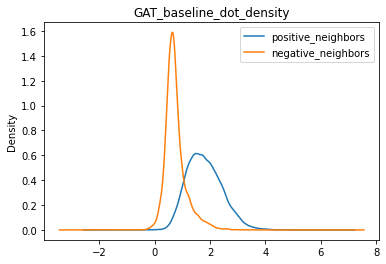

In [22]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [23]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2188.33it/s]


((6116, 2), 0.0018422168633773623, 0.9334125321835833, 0.5206779519372033)

# GAT ( baseline + crosswalk)

In [24]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

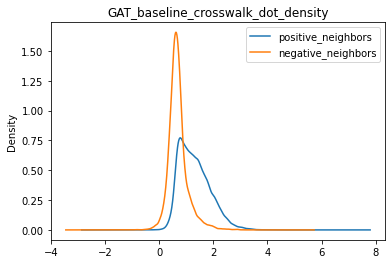

In [25]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [26]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2191.19it/s]


((6112, 2), 0.0016780772221224492, 0.8385589473074686, 0.5069089706026791)

# GAT ( r2v)

In [27]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

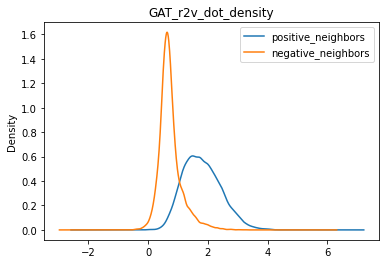

In [28]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [29]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2028.85it/s]


((6116, 2), 0.001853905965492103, 0.9359346764798098, 0.5306024391885653)

# GAT ( r2v + crosswalk)

In [30]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

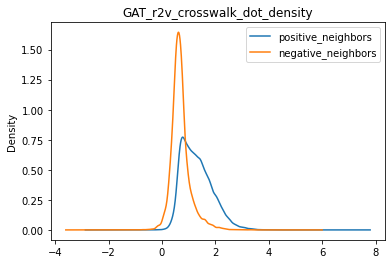

In [31]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [32]:
# # create edge_list
batch_size = 200

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1790.52it/s]


((6116, 2), 0.0016397778925225127, 0.8365372601268477, 0.4978152816148693)

# plot statistical parity scores

# gini sp scores

GCN_baseline 0.5261224028568245
GCN_baseline_crosswalk 0.4867953766912046
GCN_r2v 0.5211845134030308
GCN_r2v_crosswalk 0.5014600640875436
GAT_baseline 0.5206779519372033
GAT_baseline_crosswalk 0.5069089706026791
GAT_r2v 0.5306024391885653
GAT_r2v_crosswalk 0.4978152816148693


Text(0.5, 1.0, 'gini statistical parity scores')

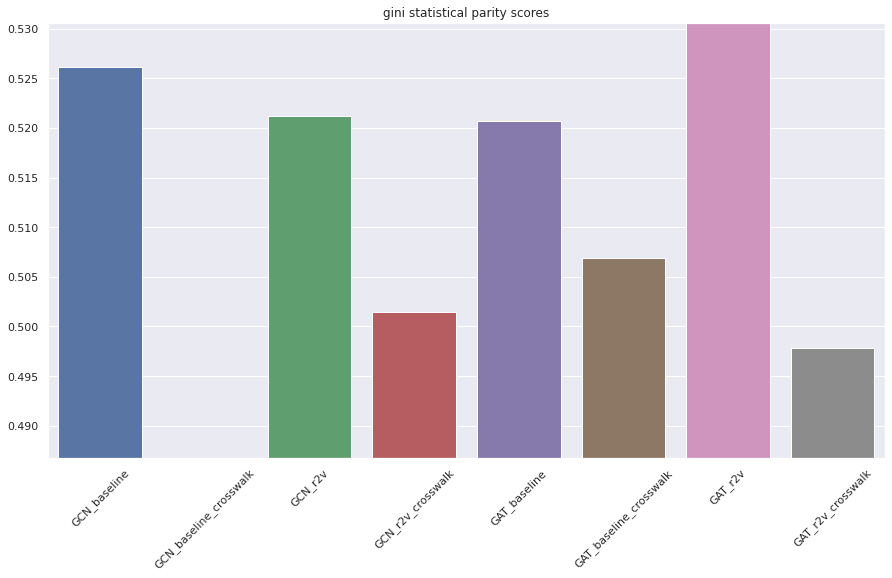

In [33]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

GCN_baseline 0.0018293657232787864
GCN_baseline_crosswalk 0.0016158871522523334
GCN_r2v 0.0018356730662020158
GCN_r2v_crosswalk 0.0016784028273395648
GAT_baseline 0.0018422168633773623
GAT_baseline_crosswalk 0.0016780772221224492
GAT_r2v 0.001853905965492103
GAT_r2v_crosswalk 0.0016397778925225127


Text(0.5, 1.0, 'statistical parity scores')

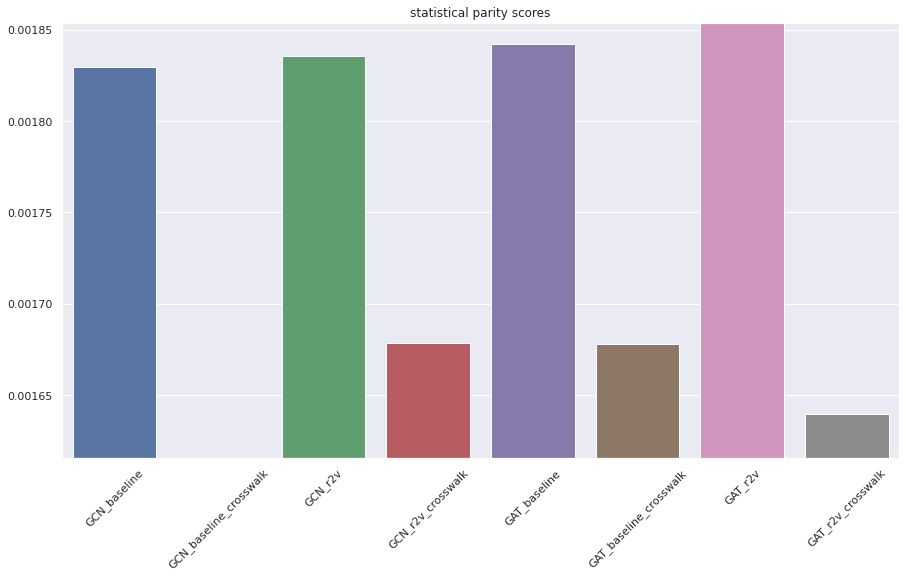

In [34]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

GCN_baseline 0.9294280506950169
GCN_baseline_crosswalk 0.8033138054486293
GCN_r2v 0.9317536978480719
GCN_r2v_crosswalk 0.8039918421765601
GAT_baseline 0.9334125321835833
GAT_baseline_crosswalk 0.8385589473074686
GAT_r2v 0.9359346764798098
GAT_r2v_crosswalk 0.8365372601268477


Text(0.5, 1.0, 'roc scores')

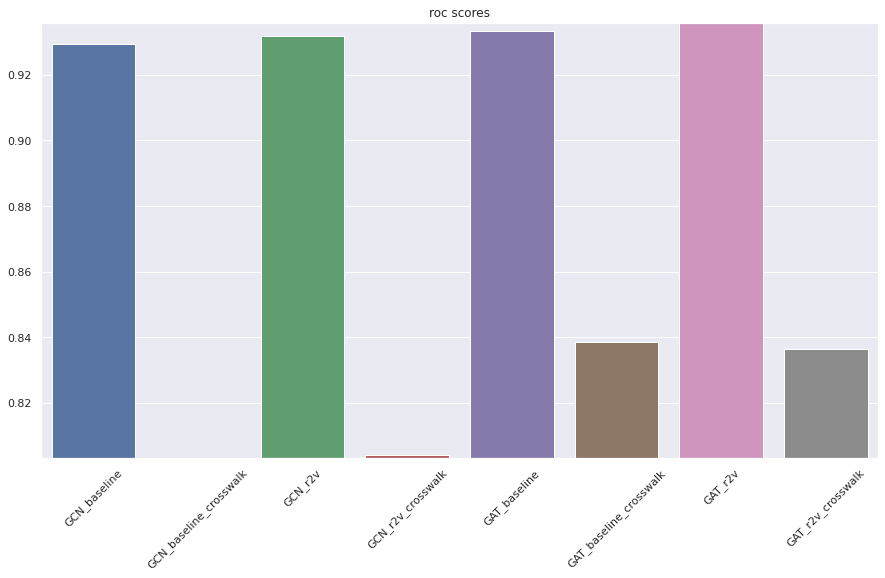

In [35]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [36]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  200
        A = embs[m]
        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2250.77it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2097.50it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2281.17it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2185.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1685.59it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2240.95it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2225.09it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1814.80it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2093.31it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1856.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2032.62it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1542.50it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2084.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1747.75it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1866.62it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1723.10it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1673.93it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1731.04it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1910.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2176.41it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

Text(0.5, 1.0, 'gini scores vs # nn')

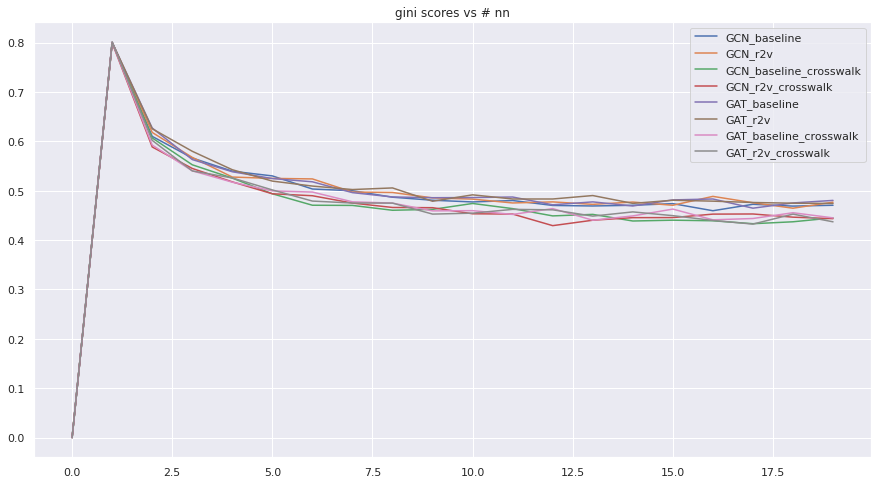

In [37]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

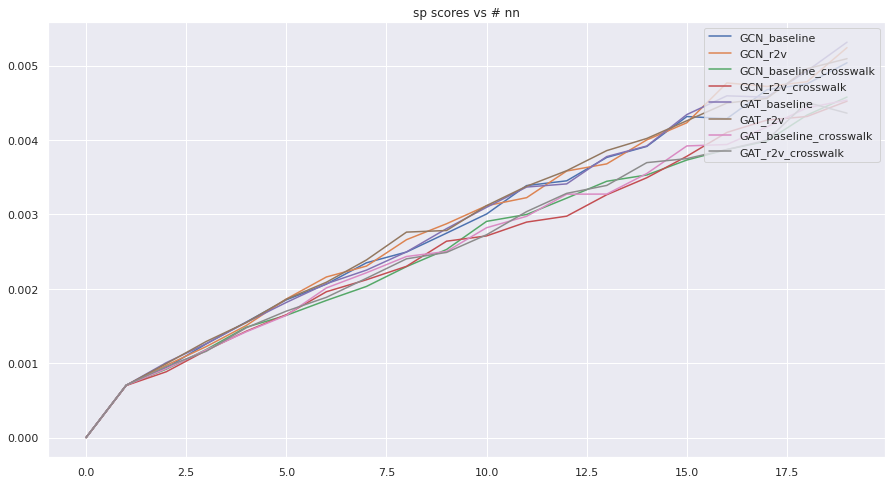

In [38]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [39]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        dot = create_dot_df(A)
        scores[idx] = get_roc_score(dot)
    return np.mean(scores)


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        edges = snakemake_utils.return_new_graph(A, K, 200)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return np.mean(scores), np.mean(scores_gini)

GCN_baseline 0.9311173741416805
GCN_baseline_crosswalk 0.8011355247890528
GCN_r2v 0.9302082039061164
GCN_r2v_crosswalk 0.8008662011810811
GAT_baseline 0.9352659866466349
GAT_baseline_crosswalk 0.8360715767019729
GAT_r2v 0.935687599727341
GAT_r2v_crosswalk 0.8357996452346672


Text(0.5, 1.0, 'roc scores')

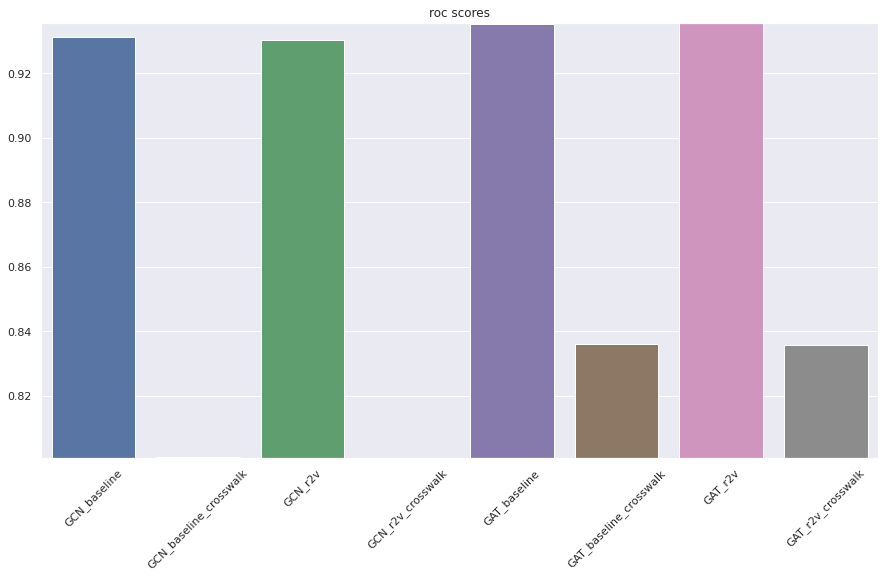

In [40]:

roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1666.72it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2382.45it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2051.00it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2168.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1688.64it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1944.51it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2327.58it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2190.05it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

GCN_baseline 0.0017918692820544293
GCN_baseline_crosswalk 0.0016930021828132857
GCN_r2v 0.0018262344463230492
GCN_r2v_crosswalk 0.0016397731576871383
GAT_baseline 0.0018055420941815205
GAT_baseline_crosswalk 0.001700337514697359
GAT_r2v 0.001803676795274535
GAT_r2v_crosswalk 0.0016700545232460763


Text(0.5, 1.0, 'statistical parity scores')

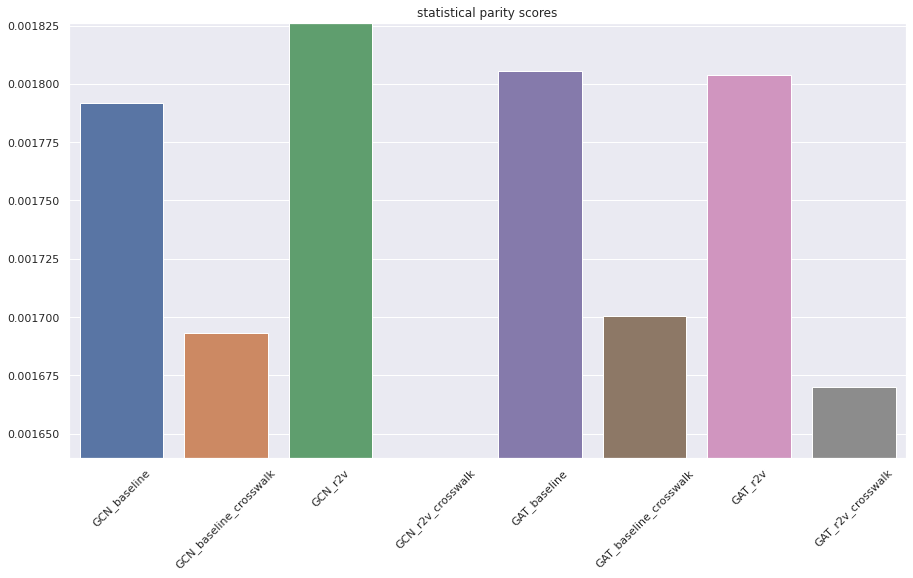

In [41]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: v[0] for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.5202578946776123
GCN_baseline_crosswalk 0.4983325168531182
GCN_r2v 0.5225072531512345
GCN_r2v_crosswalk 0.4889928245402194
GAT_baseline 0.5210223536171043
GAT_baseline_crosswalk 0.5012392203689172
GAT_r2v 0.5214705059756105
GAT_r2v_crosswalk 0.4987429354912944


Text(0.5, 1.0, 'gini statistical parity scores')

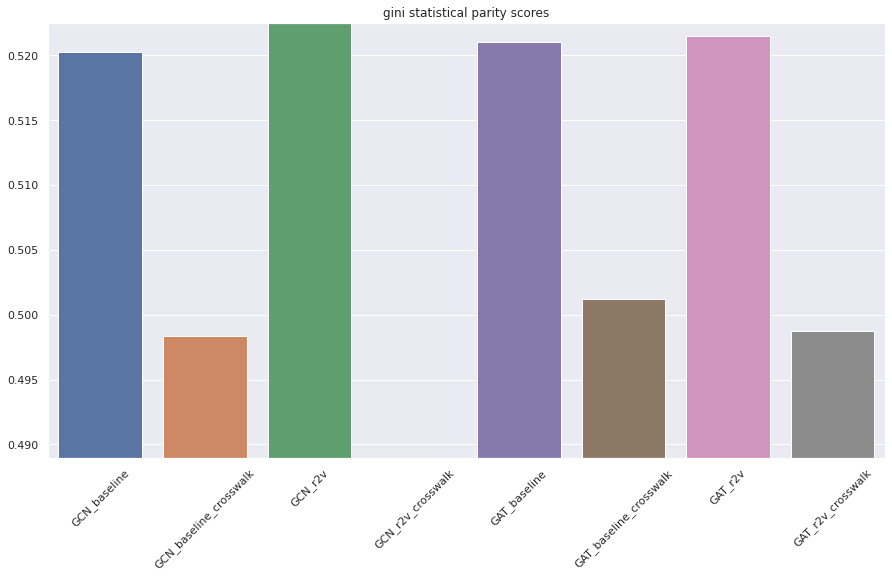

In [42]:
gini_score = {m: v[1] for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")